In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch # deep learning
import torchvision # image preprocessing
from PIL import Image # read image
import matplotlib.pyplot as plt # image plotting
import os

In [3]:
# Get labels
df = pd.read_csv(os.path.join('dogbreeds/dogs.csv'))
df.head()

,filepaths,labels,data set
0,train/Afghan/001.jpg,Afghan,train
1,train/Afghan/002.jpg,Afghan,train
2,train/Afghan/003.jpg,Afghan,train
3,train/Afghan/004.jpg,Afghan,train
4,train/Afghan/005.jpg,Afghan,train


In [4]:
# define the image preprocessing transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p = 0.5)
])


In [5]:
# create datasets
trainset = torchvision.datasets.ImageFolder("dogbreeds/train", transform = transform)
validset = torchvision.datasets.ImageFolder("dogbreeds/valid", transform = transform)
testset = torchvision.datasets.ImageFolder("dogbreeds/test", transform = transform)


In [6]:
# create DataLoaders
batch_size = 64

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [11]:
# double check shapes
data_iter = iter(train_loader) 
images, labels = next(data_iter)
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


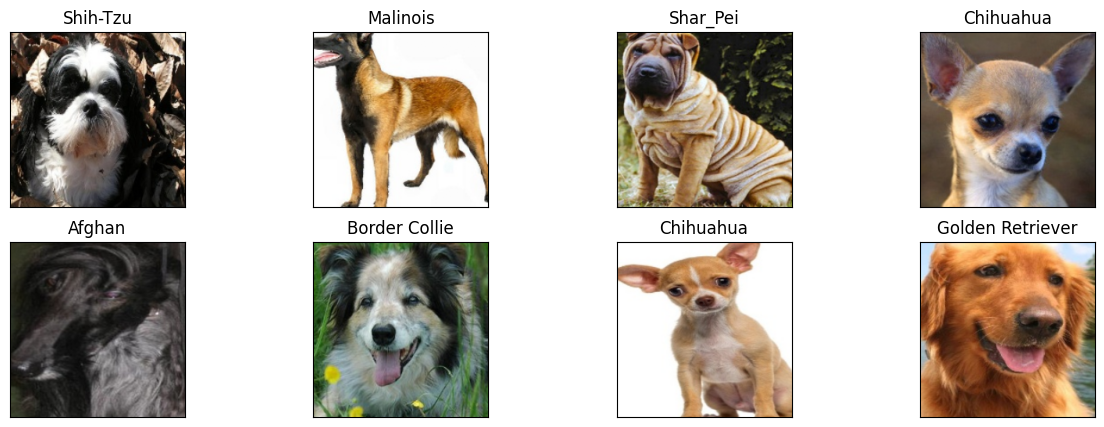

In [12]:
# visualize the data
data_iter = iter(train_loader)
images, labels = next(data_iter)
images, labels = images.numpy() , labels.numpy()

fig = plt.figure(figsize = (15,5))

for i in range(int(batch_size/8)):
    ax = fig.add_subplot(2 , int(batch_size/16) , i + 1 , xticks = [] , yticks = [])
    ax.imshow(np.transpose(images[i] , (1,2,0)) , cmap = 'gray')
    ax.set_title(trainset.classes[labels[i]])


In [10]:
import torch.nn as nn

# model
model = nn.Sequential(
    # 3x224x224
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),
    # 64x112x112
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 128x56x56
    nn.Flatten(),
    # 401408
    nn.Linear(401408, 2048),
    nn.ReLU(),
    # 2048
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Linear(256, trainset.classes),
    nn.LogSoftmax(dim=1)
)


In [11]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# training + validation
num_epochs = 36
for epoch in range(num_epochs):
    # training
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


KeyboardInterrupt: 

In [41]:
# save the model
torch.save(model.state_dict(), 'linear_model1116.pth')

In [55]:
model.load_state_dict(torch.load('model1115.pth'))

<All keys matched successfully>

In [56]:
model.eval()  
running_test_loss = 0.0
all_predictions = []
all_true_values = []

num_samples_to_display = 50
sample_count = 0  

with torch.no_grad(): 
    for batch_idx, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        test_loss = criterion(outputs, labels)
        running_test_loss += test_loss.item()
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())  
        all_true_values.extend(labels.cpu().numpy()) 

        # Display predictions and labels for a few samples
        if sample_count < num_samples_to_display:
            for i in range(len(predicted)):
                if sample_count >= num_samples_to_display:
                    break
                print(f"Sample {sample_count + 1}: Predicted: {predicted[i].item()}, True Label: {labels[i].item()}")
                sample_count += 1


# Average test loss
average_test_loss = running_test_loss / len(test_loader)
print(f"Test Loss after training: {average_test_loss:.4f}")

# Compute accuracy
correct = sum(p == t for p, t in zip(all_predictions, all_true_values))
accuracy = correct / len(all_true_values) * 100
print(f"Test Accuracy: {accuracy:.2f}%")


Sample 1: Predicted: 49, True Label: 11
Sample 2: Predicted: 49, True Label: 44
Sample 3: Predicted: 49, True Label: 67
Sample 4: Predicted: 49, True Label: 30
Sample 5: Predicted: 49, True Label: 13
Sample 6: Predicted: 49, True Label: 64
Sample 7: Predicted: 49, True Label: 55
Sample 8: Predicted: 49, True Label: 22
Sample 9: Predicted: 49, True Label: 9
Sample 10: Predicted: 49, True Label: 51
Sample 11: Predicted: 49, True Label: 31
Sample 12: Predicted: 49, True Label: 60
Sample 13: Predicted: 49, True Label: 47
Sample 14: Predicted: 49, True Label: 67
Sample 15: Predicted: 49, True Label: 5
Sample 16: Predicted: 49, True Label: 45
Sample 17: Predicted: 49, True Label: 45
Sample 18: Predicted: 49, True Label: 10
Sample 19: Predicted: 49, True Label: 30
Sample 20: Predicted: 49, True Label: 32
Sample 21: Predicted: 49, True Label: 6
Sample 22: Predicted: 49, True Label: 55
Sample 23: Predicted: 49, True Label: 51
Sample 24: Predicted: 49, True Label: 50
Sample 25: Predicted: 49, Tr

KeyboardInterrupt: 